## Last Exercise: Adsorption Algorithm

### 1) Implement Adsorption Algorithm

Fill in the appropriate blanks.

Note that Adsorption, or family of Label Propagation in general is supposed to be fast. So you do not need to bother with checking convergence and just use a maximum number of iterations.

It can be either synchronous (you update l_inferred after iterating everynode) or asynchronous (you update current node's l_inferred then proceed to next one in the same iteration). Both is fine. Here I implemented asynchronous version. 

In [1]:
import networkx as nx
from math import log
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
# Load the Graph of Zachary's Karate Club
G = nx.karate_club_graph()
labels = [lab[1] for lab in G.nodes(data = 'club')]
colors = ["blue"  if (label == 'Mr. Hi') else 'green' for label in labels]

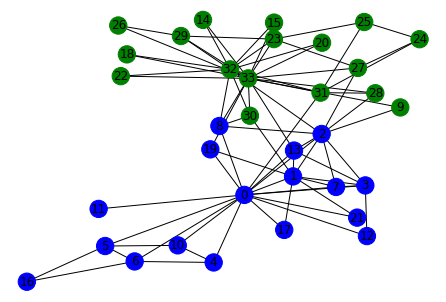

In [3]:
# Ground Truth For The Karate Graph
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color = colors, pos = pos, label = 'Ground Truth')
plt.show()

In [4]:
# Initialize vectors and parameters
nodes_num = len(G.nodes())
edge_num = len(G.edges())
label_num = len(set(labels)) + 1
degrees = np.array([tup[1] for tup in G.degree()])

In [5]:
# We need seeds to propagate their label. You can randomly use some of them.  
def randomly_sample_ground_truth(frac):
    l_apriori = np.zeros((nodes_num, label_num))

    # Ground truth
    sample = random.sample(list(G.nodes()), int(nodes_num*frac))
    club_index_mapping = {
        'Mr. Hi': 0,
        'Officer': 1
    }

    for node in sample:
        club = G.nodes[node]['club']
        club_index = club_index_mapping[club]
        l_apriori[int(node)][club_index] = 1

    return l_apriori

In [6]:
seed_l_apriori = randomly_sample_ground_truth(frac = 0.5)

In [7]:
# seed_l_apriori[[33,32,8],:] = 0
# seed_l_apriori[[33,32,8],0] = 1

In [8]:
seed_l_apriori

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 1., 0.]])

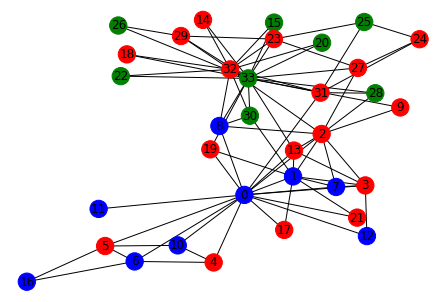

In [9]:
color_map = []
for node_labels in seed_l_apriori:
    if (node_labels[0] == 1):
        color_map.append('blue')
    elif(node_labels[1] == 1):
        color_map.append('green')
    else:
        color_map.append('red')

nx.draw(G, with_labels=True, node_color = color_map, pos = pos, label = 'Seed Nodes')
plt.show()

Note that probability parameters in the original paper proposing the algorithm (and the lecture) are set heuristically. If the outcome is not as expected, i.e. everynode is labeled as unknown, play with the probability parameters. 

Warning: For this graph, set abandon probability to zero.

In [10]:
l_apriori = np.array(seed_l_apriori)
l_inferred = l_apriori
l_unknown = np.zeros((nodes_num, label_num))
l_unknown[:, -1] = np.ones(nodes_num)

In [11]:
H = np.zeros(nodes_num)
for i, node in enumerate(G.nodes()):
    H[i] = -1 * log(1 / degrees[i])

c = np.zeros(nodes_num)
for i in range(0, nodes_num):
    c[i] = log(2) / log(2 + degrees[i])

d = np.zeros(nodes_num)
labeled = np.sum(l_apriori, axis=1)
z = np.zeros(nodes_num)

for i in range(0, nodes_num):
    if (labeled[i] != 0):
        d[i] = (1-c[i]) * sqrt(H[i])

    z[i] = max(c[i] + d[i], 1)

p_inj = d / z
p_cont = 1 - p_inj
p_abandon = np.zeros(nodes_num)

In [12]:
# THE ALGORITHM
max_iter = 3
for i in range(0, max_iter):
    for i, node in enumerate(G.nodes()):
        l_inferred_temp = np.zeros((label_num))
        for neigh in G.neighbors(n=node):  # note: in the example graph, indexes are also node names
            l_inferred_temp += l_inferred[neigh]
        
        l_inferred_temp = (1 / degrees[i]) * l_inferred_temp
        inj = p_inj[i] * l_apriori[i]
        cont = p_cont[i] * l_inferred_temp
        abandon = p_abandon[i] * l_unknown[i]

        l_inferred[i] = inj + cont + abandon


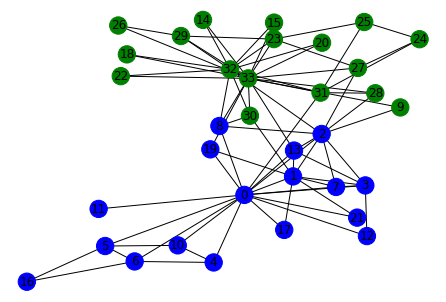

In [13]:
# FINAL LABELS
color_map = []
labeled = 0
for node_labels in l_inferred:
    if (node_labels[0] > 0.5):
        color_map.append('blue')
        labeled += 1
    elif(node_labels[1] > 0.5):
        color_map.append('green')
        labeled += 1
    else:
        color_map.append('red')

nx.draw(G, with_labels=True, node_color = color_map, pos = pos, label = 'Final Labels')
plt.show()

In [14]:
print(l_inferred)

[[0.86763983 0.03118011 0.        ]
 [0.76581037 0.08507462 0.        ]
 [0.5182101  0.3259921  0.        ]
 [0.73831631 0.13297447 0.        ]
 [0.93402654 0.01199994 0.        ]
 [0.94472989 0.00937978 0.        ]
 [0.95875021 0.00592312 0.        ]
 [0.79855067 0.08066504 0.        ]
 [0.55759428 0.32041892 0.        ]
 [0.28457131 0.60118059 0.        ]
 [0.94174814 0.0090676  0.        ]
 [0.86763983 0.03118011 0.        ]
 [0.82103973 0.06257047 0.        ]
 [0.58818183 0.29031808 0.        ]
 [0.10808718 0.75499301 0.        ]
 [0.08071113 0.74174674 0.        ]
 [0.96218858 0.00509877 0.        ]
 [0.8167251  0.05812736 0.        ]
 [0.10808718 0.75499301 0.        ]
 [0.56146091 0.3308746  0.        ]
 [0.08071113 0.74174674 0.        ]
 [0.8167251  0.05812736 0.        ]
 [0.08071113 0.74174674 0.        ]
 [0.09448534 0.6854602  0.        ]
 [0.1401696  0.5877303  0.        ]
 [0.08648216 0.61661604 0.        ]
 [0.0323932  0.76047134 0.        ]
 [0.20094939 0.61888792 0.  

## 2. Compare With Louvain Method

First, install louvain for networkx by 
pip install python-louvain

Then run the following code to see the results. How the outcome is different then the ground truth and the outcome of Adsorption algorithm?

In [15]:
import community

{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 2, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 2, 15: 2, 16: 1, 17: 0, 18: 2, 19: 0, 20: 2, 21: 0, 22: 2, 23: 3, 24: 3, 25: 3, 26: 2, 27: 3, 28: 3, 29: 2, 30: 2, 31: 3, 32: 2, 33: 2}
0
0
0
0
1
1
1
0
2
0
1
0
0
0
2
2
1
0
2
0
2
0
2
3
3
3
2
3
3
2
2
3
2
2
['yellow', 'yellow', 'yellow', 'yellow', 'green', 'green', 'green', 'yellow', 'blue', 'yellow', 'green', 'yellow', 'yellow', 'yellow', 'blue', 'blue', 'green', 'yellow', 'blue', 'yellow', 'blue', 'yellow', 'blue', 'magenta', 'magenta', 'magenta', 'blue', 'magenta', 'magenta', 'blue', 'blue', 'magenta', 'blue', 'blue']


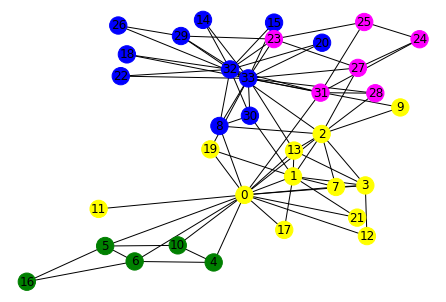

In [16]:
community_dict = community.best_partition(G)
print(community_dict)

# Color mapping for community names
colors = []
for key, item in community_dict.items():
    print(item)
    if(item == 0):
        colors.append('yellow')
    elif(item == 1):
        colors.append('green')
    elif(item == 2):
        colors.append('blue')
    elif(item == 3):
        colors.append('magenta')
    elif(item == 4):
        colors.append('cyan')
    elif(item == 5):
        colors.append('black')
    else:
        colors.append('white')


print(colors)
plt.clf()
nx.draw(G, with_labels=True, node_color = colors, pos = pos, label = 'Louvain Labels')
plt.show()

## 3. Manually Labeled Seeds (Exercise)

In the first part, we randomly used some of the ground truth as seed, so you may have had different results depending on how lucky you are.

Try labeling a handful of nodes (cheating from the ground truth) and evaluate the results. 

First, try labeling high degree nodes, then try labeling low degree nodes.

In a real setting, when you have huge amounts of unlabeled data, you can try this method; manually annotate some seed nodes then predict the rest.

<br>
Labelling high degree nodes apriori dominates the graph with the color of those nodes.